In [28]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# Groud truth - Median

In [17]:
df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')

gt['lh'] = (gt[['h']] > np.median(gt['h'])) * 1
gt['le'] = (gt[['e']] > np.median(gt['e'])) * 1
gt['lx'] = (gt[['x']] > np.median(gt['x'])) * 1
gt['la'] = (gt[['a']] > np.median(gt['a'])) * 1
gt['lc'] = (gt[['c']] > np.median(gt['c'])) * 1
gt['lo'] = (gt[['o']] > np.median(gt['o'])) * 1
gt

,h,e,x,a,c,o,lh,le,lx,la,lc,lo
id,,,,,,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,1,0,0,0,0,0
3,3.38,3.44,3.50,3.50,4.50,3.81,0,0,1,1,1,1
4,3.19,3.75,3.69,3.19,2.63,2.63,0,1,1,0,0,0
5,3.25,3.63,2.13,3.56,3.63,2.31,0,1,0,1,1,0
6,3.25,2.75,3.50,2.50,3.75,5.00,0,0,1,0,1,1
7,4.06,3.06,3.38,2.88,2.50,4.19,1,0,1,0,0,1
8,3.94,2.94,3.19,3.75,3.38,3.81,1,0,1,1,0,1
9,4.44,4.00,3.38,3.75,3.69,3.31,1,1,1,1,1,0
10,3.63,3.25,3.50,3.31,3.88,2.69,1,0,1,1,1,0


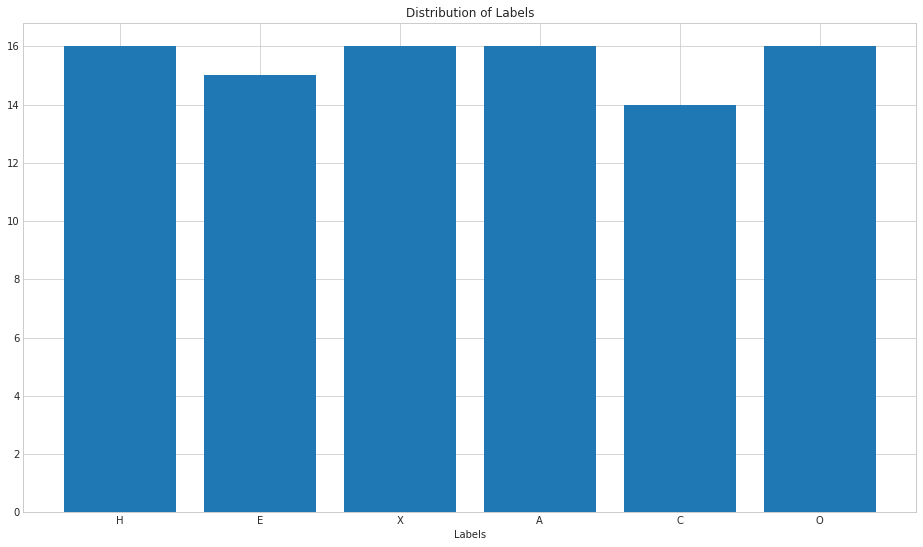

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# EEG data

In [19]:
def load_data():
    path, folders, filenames = next(walk('./data'))

    filenames.remove('11-audio.csv')
    filenames.remove('11-image.csv')

    filenames.remove('36-audio.csv')
    filenames.remove('36-image.csv')

    path = './data'
    columns = {'Unnamed: 1':'Fp1',
            'Unnamed: 2':'Fp2',
            'Unnamed: 3':'F3',
            'Unnamed: 4':'F4',
            'Unnamed: 5':'F7',
            'Unnamed: 6':'F8',
            'Unnamed: 7':'P7',
            'Unnamed: 8':'P8'}

    EEG_audio, EEG_image = dict(), dict()
    from itertools import product
    categories = [1,2,3,4,5]
    blocks = [1,2]
    with tqdm(filenames) as t:
        for filename in t:
            t.set_description(f"{filename}")
            participant_id, stimuli = filename.split('-')
            stimuli = stimuli.rstrip('.csv')
            data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
            # Aviod warning on stim has negative value
            marker = np.array(data['Marker'])
            marker[marker == '-1'] = '1'
            data['Marker'] = marker

            if(stimuli == 'audio'):
                EEG_audio[int(participant_id)] = data
            elif(stimuli == 'image'):
                EEG_image[int(participant_id)] = data
            else:
                raise ValueError(f"Stimuli:{stimuli} is unexpected.")
    return EEG_audio, EEG_image


In [20]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data()
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')

Load data from cache


# Pre process with PSD + log + mne ICA

In [21]:
# raw = dataframe_to_raw(EEG_image[33], sfreq=250)

# # Preprocess
# raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
# raw.filter(1., None, verbose=False) # Slow drift

# events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
# events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
# # Check data
# if(events.shape[0] != 50):
#     raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
# epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
# if(epochs.get_data().shape[0] != 50):
#     raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

# # for evoked in epochs.iter_evoked():
# #     reduc = ica.apply(evoked, verbose=False)
# #     power,freq = mne.time_frequency.psd_array_welch(reduc.data[:6],sfreq=250,n_fft=128, verbose=False)
# #     break

In [22]:
# # Extract features
# events = np.array([int(event / 100) for event in epochs.events[:,2]])
# Y = None
# X = None
# csp = mne.decoding.CSP(n_components=8, transform_into='csp_space', norm_trace=True)
# data = csp.fit_transform(epochs.get_data()[:,:8,:], events)
# print(data.shape)
# for index, evoked in enumerate(epochs.iter_evoked()):
#     # event = int(evoked.comment[0])
#     # events.append(event)
#     power,freq = mne.time_frequency.psd_array_welch(data[index],sfreq=250,n_fft=128, verbose=False)
#     row = power
#     row = np.expand_dims(row, axis=0)
#     row = 10 * np.log10(row)
#     if(type(X) == type(None)): X = row
#     else: X = np.concatenate( [X, row ], axis=0 )

#     label = gt.loc[33][['lh','le','lx','la','lc','lo']].to_numpy()
#     label = np.expand_dims(label, axis=0)
#     if(type(Y) == type(None)): Y = label
#     else: Y = np.concatenate( [Y, label ], axis=0 )
# print(events.shape, X.shape, Y.shape)

In [23]:
# data = X.copy().reshape(50,-1)
# # data
# print(data.shape)
# data_norm = normalize(data.copy(), axis=0)
# mnb = GaussianNB()
# mnb.fit(data_norm, events)
# acc = sum(mnb.predict(data_norm) == events) / len(events)
# scores = cross_val_score(mnb, data_norm, events)
# print(acc, scores)

In [24]:
# proj_data.shape

In [25]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
def build_data(p_num, EEG,ids):
    X = None
    Y = None
    t_start, t_stop = (2.0,4.0)
    with tqdm(ids) as t:
        for index, id in enumerate(t):
            t.set_description(f"{id}")
            print(f"p_no={p_num}|index={index}|id={id}")
            raw = dataframe_to_raw(EEG[id], sfreq=250)
            
            # Preprocess
            raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
            raw.filter(1., None, verbose=False) # Slow drift
            # ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
            # ica.fit(raw, verbose=False)
            # raw = ica.apply(raw, verbose=False)

            events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
            events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
            # Check data
            if(events.shape[0] != 50):
                raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
            epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)
            if(epochs.get_data().shape[0] != 50):
                raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

            # Extract features
            events = np.array([int(event / 100) for event in epochs.events[:,2]])
            csp = mne.decoding.CSP(n_components=5, transform_into='csp_space', norm_trace=True)
            data = csp.fit_transform(epochs.get_data()[:,:8,:], events)
            for index_inner, evoked in enumerate(epochs.iter_evoked()):
                power,freq = mne.time_frequency.psd_array_welch(data[index_inner],sfreq=250,n_fft=128, verbose=False)
                row = power
                row = np.expand_dims(row, axis=0)
                row = 10 * np.log10(row)
                if(type(X) == type(None)): X = row
                else: X = np.concatenate( [X, row ], axis=0 )

                label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
                label = np.expand_dims(label, axis=0)
                if(type(Y) == type(None)): Y = label
                else: Y = np.concatenate( [Y, label ], axis=0 )

    print(f"{p_num} done| {ids}")
    return np.array(X),np.array(Y),freq

def get_accuracy(X,y):
    result = []
    traits = ["h","e","x","a","c","o"]
    for index,label in enumerate(traits):
        y = Y[:,index]
        X_copy = X.copy()
        X_copy = normalize(X_copy,axis=0)
        mnb = GaussianNB()
        mnb.fit(X_copy, y)
        acc = sum(mnb.predict(X_copy) == y) / len(y)
        scores = cross_val_score(mnb, X_copy, y)
        result.append([acc,scores.mean(),scores.std()])
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
    return result

In [26]:
try:
    # [33,2,10,12,16]
    t_out = 300
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    freq = ans1[2]
    print(X.shape, Y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10
p_no=2|index=0|id=12
p_no=3|index=0|id=13
p_no=4|index=0|id=14
p_no=5|index=0|id=15
p_no=6|index=0|id=16
Computing rank from data with rank=None
    Using tolerance 6.7e-06 (2.2e-16 eps * 8 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-06 (2.2e-16 eps * 8 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-06 (2.2e-16 eps * 8 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing ran

In [29]:
X,Y = shuffle(X,Y)
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_image = []
best_image = 0
best_image_idx = -1
best_image_comb = None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        # print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        result = np.array(get_accuracy(selected_x,Y))
        print(" Averag accuracy:", result[:,0].mean(), "Average Score:", result[:,1].mean(), "Average Variance:", result[:,2].mean())
        result_image.append(result)
        if(result[:,1].mean() > best_image):
            best_image = result[:,1].mean()
            best_image_idx = len(result_image)-1
            best_image_comb = band_names[ list(comb) ]

print(f"Best Score is {best_image} at index {best_image_idx} with combination {best_image_comb}")

/tmp/ipykernel_94991/1983967163.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


==================== Number 1 ====================
  ['Delta']
h | Accuracy: 0.54 Scores: 0.53 (+/- 0.07)
e | Accuracy: 0.63 Scores: 0.62 (+/- 0.03)
x | Accuracy: 0.62 Scores: 0.62 (+/- 0.05)
a | Accuracy: 0.59 Scores: 0.59 (+/- 0.08)
c | Accuracy: 0.64 Scores: 0.64 (+/- 0.05)
o | Accuracy: 0.60 Scores: 0.59 (+/- 0.06)
 Averag accuracy: 0.6024444444444444 Average Score: 0.5987777777777779 Average Variance: 0.028096755008503383
  ['Theta']
h | Accuracy: 0.57 Scores: 0.55 (+/- 0.03)
e | Accuracy: 0.67 Scores: 0.67 (+/- 0.04)
x | Accuracy: 0.65 Scores: 0.65 (+/- 0.04)
a | Accuracy: 0.58 Scores: 0.58 (+/- 0.05)
c | Accuracy: 0.61 Scores: 0.62 (+/- 0.05)
o | Accuracy: 0.60 Scores: 0.59 (+/- 0.08)
 Averag accuracy: 0.6125555555555556 Average Score: 0.6104444444444445 Average Variance: 0.023373935586831134
  ['Alpha']
h | Accuracy: 0.57 Scores: 0.57 (+/- 0.03)
e | Accuracy: 0.65 Scores: 0.65 (+/- 0.05)
x | Accuracy: 0.65 Scores: 0.64 (+/- 0.04)
a | Accuracy: 0.66 Scores: 0.66 (+/- 0.10)
c | A

In [30]:
try:
    # [33,2,10,12,16]
    t_out = 300
    pool = Pool()
    ids = np.array(list(EEG_audio.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_audio,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_audio,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_audio,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_audio,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_audio,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_audio,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    freq = ans1[2]
    print(X.shape, Y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10
p_no=2|index=0|id=12
p_no=3|index=0|id=13
p_no=4|index=0|id=14
p_no=5|index=0|id=15
p_no=6|index=0|id=16
Computing rank from data with rank=None
    Using tolerance 8.6e-06 (2.2e-16 eps * 8 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-06 (2.2e-16 eps * 8 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-05 (2.2e-16 eps * 8 dim * 8.8e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing ran

In [31]:
X,Y = shuffle(X,Y)
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_audio = []
best_audio = 0
best_audio_idx = -1
best_audio_comb = None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        # print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        result = np.array(get_accuracy(selected_x,Y))
        print(" Averag accuracy:", result[:,0].mean(), "Average Score:", result[:,1].mean(), "Average Variance:", result[:,2].mean())
        result_audio.append(result)
        if(result[:,1].mean() > best_audio):
            best_audio = result[:,1].mean()
            best_audio_idx = len(result_audio)-1
            best_audio_comb = band_names[ list(comb) ]

print(f"Best Score is {best_audio} at index {best_audio_idx} with combination {best_audio_comb}")

/tmp/ipykernel_94991/1958830028.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


==================== Number 1 ====================
  ['Delta']
h | Accuracy: 0.58 Scores: 0.57 (+/- 0.03)
e | Accuracy: 0.66 Scores: 0.66 (+/- 0.04)
x | Accuracy: 0.54 Scores: 0.53 (+/- 0.02)
a | Accuracy: 0.64 Scores: 0.64 (+/- 0.06)
c | Accuracy: 0.61 Scores: 0.60 (+/- 0.07)
o | Accuracy: 0.61 Scores: 0.61 (+/- 0.06)
 Averag accuracy: 0.6081111111111112 Average Score: 0.601 Average Variance: 0.02357107266017368
  ['Theta']
h | Accuracy: 0.63 Scores: 0.62 (+/- 0.07)
e | Accuracy: 0.67 Scores: 0.66 (+/- 0.04)
x | Accuracy: 0.57 Scores: 0.56 (+/- 0.03)
a | Accuracy: 0.60 Scores: 0.59 (+/- 0.06)
c | Accuracy: 0.58 Scores: 0.57 (+/- 0.06)
o | Accuracy: 0.67 Scores: 0.67 (+/- 0.06)
 Averag accuracy: 0.6204444444444445 Average Score: 0.6123333333333333 Average Variance: 0.026352388760689138
  ['Alpha']
h | Accuracy: 0.61 Scores: 0.60 (+/- 0.08)
e | Accuracy: 0.68 Scores: 0.68 (+/- 0.08)
x | Accuracy: 0.65 Scores: 0.64 (+/- 0.04)
a | Accuracy: 0.65 Scores: 0.65 (+/- 0.04)
c | Accuracy: 0.61 

In [32]:
result_image = np.array(result_image)
result_audio = np.array(result_audio)


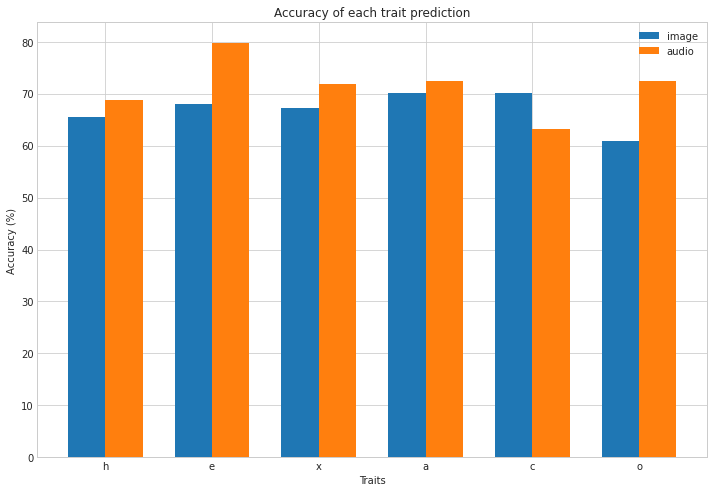

In [33]:
traits = ["h","e","x","a","c","o"]
width =.35

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(np.arange(6)      ,result_image[best_image_idx,:,0] * 100, width=width, label='image', ecolor='black', capsize=10)
ax.bar(np.arange(6)+width,result_audio[best_audio_idx,:,0] * 100, width=width, label='audio', ecolor='black', capsize=10)

ax.set_xlabel('Traits')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of each trait prediction')
ax.set_xticks(np.arange(6) + width / 2)
ax.set_xticklabels(traits)
ax.legend()

plt.show()

In [34]:
print(f"On average, image accuracy is {round(result_image[best_image_idx,:,0].mean(),2)} and audio accuracy is {round(result_audio[best_audio_idx,:,0].mean(),2)}")
print(f"On average, image    score is {round(result_image[best_image_idx,:,1].mean(),2)} and audio    score is {round(result_audio[best_audio_idx,:,1].mean(),2)}")
print(f"On average, image      std is {round(result_image[best_image_idx,:,2].mean(),2)} and audio      std is {round(result_audio[best_audio_idx,:,2].mean(),2)}")

On average, image accuracy is 0.67 and audio accuracy is 0.71
On average, image    score is 0.67 and audio    score is 0.71
On average, image      std is 0.02 and audio      std is 0.04


In [35]:
for index, trait in enumerate(traits):
    print(f"Image {trait}: Acc: {round(result_image[best_image_idx,index,0],2)} | score: {round(result_image[best_image_idx,index,1],2)} | std: score: {round(result_image[best_image_idx,index,2],2)}" )
    print(f"Audio {trait}: Acc: {round(result_audio[best_audio_idx,index,0],2)} | score: {round(result_audio[best_audio_idx,index,1],2)} | std: score: {round(result_audio[best_audio_idx,index,2],2)}" )
    print()
print(f"Image: Best Score is {best_image} at index {best_image_idx} with combination {best_image_comb}")
print(f"Audio: Best Score is {best_audio} at index {best_audio_idx} with combination {best_audio_comb}")

Image h: Acc: 0.66 | score: 0.65 | std: score: 0.02
Audio h: Acc: 0.69 | score: 0.66 | std: score: 0.05

Image e: Acc: 0.68 | score: 0.67 | std: score: 0.02
Audio e: Acc: 0.8 | score: 0.8 | std: score: 0.04

Image x: Acc: 0.67 | score: 0.67 | std: score: 0.02
Audio x: Acc: 0.72 | score: 0.71 | std: score: 0.03

Image a: Acc: 0.7 | score: 0.69 | std: score: 0.03
Audio a: Acc: 0.72 | score: 0.72 | std: score: 0.04

Image c: Acc: 0.7 | score: 0.7 | std: score: 0.02
Audio c: Acc: 0.63 | score: 0.63 | std: score: 0.03

Image o: Acc: 0.61 | score: 0.6 | std: score: 0.03
Audio o: Acc: 0.72 | score: 0.72 | std: score: 0.03

Image: Best Score is 0.6653333333333334 at index 22 with combination ['Theta' 'Alpha' 'Gamma']
Audio: Best Score is 0.7063333333333333 at index 24 with combination ['Alpha' 'Beta' 'Gamma']
